In [1]:
#Choose the tensorflow-v2.2.0-gpu kernel from the dropdown menu!
import numpy as np
import h5py
import math
import os
import pathlib
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Activation, Layer, ReLU, LeakyReLU
from tensorflow.keras import backend as K

In [2]:
from func import load_model, save_model

## Load dataset

In [3]:
filename = '/global/cscratch1/sd/vmikuni/ADC/BKG_dataset.h5'

In [4]:
# make sure input data has correct input shape - background training data
with h5py.File(filename, 'r') as file:
    X_train = np.array(file['X_train'])
    X_test = np.array(file['X_test'])
    X_val = np.array(file['X_val'])

## Define Dense NN architecture

In [5]:
input_shape = 57
latent_dimension = 3
num_nodes=[16,8]

In [6]:
#encoder
inputArray = Input(shape=(input_shape))
x = Dense(num_nodes[0], use_bias=False)(inputArray)
x = Activation('relu')(x)
x = Dense(latent_dimension, use_bias=False)(x)
encoder = Activation('relu')(x)

#decoder
x = Dense(num_nodes[0], use_bias=False)(encoder)
x = Activation('relu')(x)
decoder = Dense(input_shape)(x)

#create autoencoder
autoencoder = Model(inputs = inputArray, outputs=decoder)
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 57)]              0         
_________________________________________________________________
dense (Dense)                (None, 16)                912       
_________________________________________________________________
activation (Activation)      (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 48        
_________________________________________________________________
activation_1 (Activation)    (None, 3)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                48        
_________________________________________________________________
activation_2 (Activation)    (None, 16)                0     

In [7]:
autoencoder.compile(optimizer = keras.optimizers.Adam(), loss='mse')

## Train model

In [8]:
EPOCHS = 10
BATCH_SIZE = 1024

In [9]:
history = autoencoder.fit(X_train, X_train, epochs = EPOCHS, batch_size = BATCH_SIZE,
                  validation_data=(X_val, X_val))

Epoch 1/10
625/625 [==============================] - 1s 2ms/step - loss: 42.6461 - val_loss: 30.9050
Epoch 2/10
625/625 [==============================] - 1s 2ms/step - loss: 30.5014 - val_loss: 30.7416
Epoch 3/10
625/625 [==============================] - 1s 2ms/step - loss: 30.3309 - val_loss: 30.5486
Epoch 4/10
625/625 [==============================] - 1s 2ms/step - loss: 30.1388 - val_loss: 30.3463
Epoch 5/10
625/625 [==============================] - 1s 2ms/step - loss: 29.9307 - val_loss: 30.1116
Epoch 6/10
625/625 [==============================] - 1s 2ms/step - loss: 29.7136 - val_loss: 29.8809
Epoch 7/10
625/625 [==============================] - 1s 2ms/step - loss: 29.4845 - val_loss: 29.6362
Epoch 8/10
625/625 [==============================] - 1s 2ms/step - loss: 29.2525 - val_loss: 29.3886
Epoch 9/10
625/625 [==============================] - 1s 2ms/step - loss: 29.0153 - val_loss: 29.1454
Epoch 10/10
625/625 [==============================] - 1s 2ms/step - loss: 28.7738

In [11]:
model_name = 'DNN_AE'
model_directory = 'DNNS/'
if not os.path.exists(model_directory+model_name):
    os.makedirs(model_directory+model_name)
save_model(model_directory+model_name, autoencoder)

## Prediction - background

In [12]:
bkg_prediction = autoencoder.predict(X_test)

## Prediction - signals

In [13]:
# add correct signal labels
signal_labels = ['Data']

In [14]:
# add correct path to signal files
signals_file = ['/global/cscratch1/sd/vmikuni/ADC/Ato4l_lepFilter_13TeV_dataset.h5']

In [15]:
# read signal data
signal_data = []
for i, label in enumerate(signal_labels):
    with h5py.File(signals_file[i], 'r') as file:
        test_data = np.array(file['Data'])
    signal_data.append(test_data)

In [16]:
signal_results = []

for i, label in enumerate(signal_labels):
    signal_prediction = autoencoder.predict(signal_data[i])
    signal_results.append([label, signal_data[i], signal_prediction]) # save [label, true, prediction] for signal

## Save results

In [17]:
save_file = 'dnn_results'

In [18]:
with h5py.File(save_file, 'w') as file:
    file.create_dataset('BKG_input', data=X_test)
    file.create_dataset('BKG_predicted', data = bkg_prediction)
    for i, sig in enumerate(signal_results):
        file.create_dataset('%s_input' %sig[0], data=sig[1])
        file.create_dataset('%s_predicted' %sig[0], data=sig[2])

## Evaluate results

1. Plot loss distribution after prediction (check loss value for signals)
2. Plot ROC curves - how good is anomaly detection for chosen FPR threshold

# 1.

In [19]:
from func import mse_loss

In [27]:
# compute loss value (true, predicted)
total_loss = []
total_loss.append(mse_loss(X_test, bkg_prediction))
for i, signal_X in enumerate(signal_data):
    total_loss.append(mse_loss(signal_X, signal_results[i][2]))

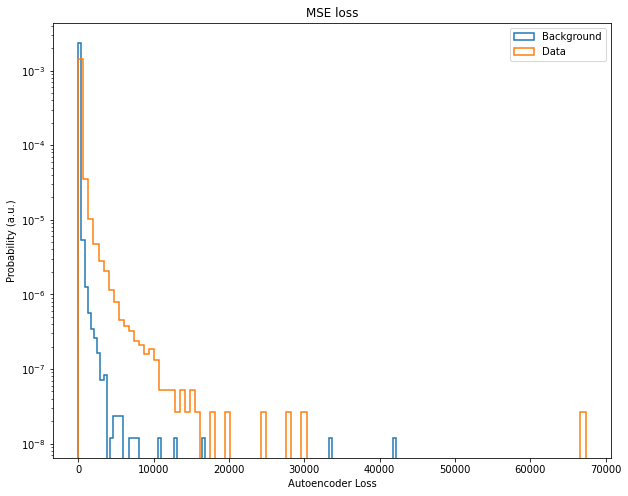

In [28]:
bin_size=100

plt.figure(figsize=(10,8))
plt.hist(total_loss[0], bins=bin_size, label="Background", density = True, histtype='step', fill=False, linewidth=1.5)
for i, label in enumerate(signal_labels):
    plt.hist(total_loss[i+1], bins=bin_size, label=label, density = True, histtype='step', fill=False, linewidth=1.5)
plt.yscale('log')
plt.xlabel("Autoencoder Loss")
plt.ylabel("Probability (a.u.)")
plt.title('MSE loss')
plt.legend(loc='best')
plt.show()

# 2.

In [29]:
from sklearn.metrics import roc_curve, auc

In [30]:
labels = np.concatenate([['Background'], np.array(signal_labels)])

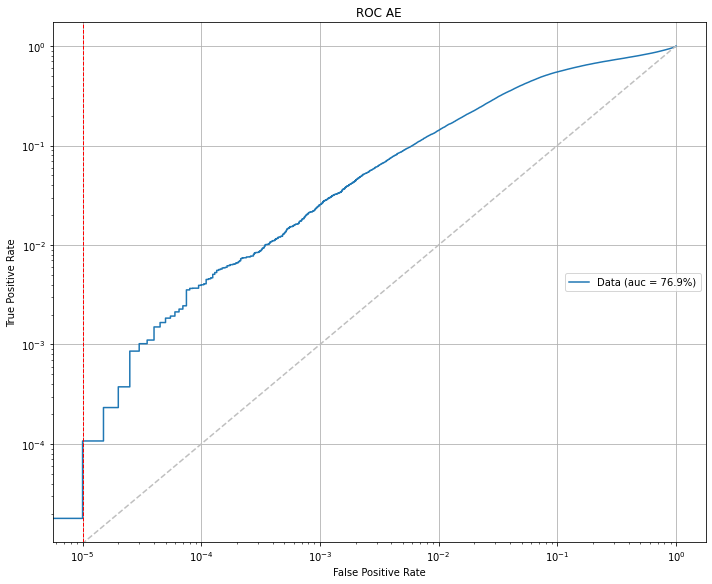

In [31]:
target_background = np.zeros(total_loss[0].shape[0])

plt.figure(figsize=(10,8))
for i, label in enumerate(labels):
    if i == 0: continue # background events
    
    trueVal = np.concatenate((np.ones(total_loss[i].shape[0]), target_background)) # anomaly=1, bkg=0
    predVal_loss = np.concatenate((total_loss[i], total_loss[0]))

    fpr_loss, tpr_loss, threshold_loss = roc_curve(trueVal, predVal_loss)

    auc_loss = auc(fpr_loss, tpr_loss)
    
    plt.plot(fpr_loss, tpr_loss, "-", label='%s (auc = %.1f%%)'%(label,auc_loss*100.), linewidth=1.5)
    
    plt.semilogx()
    plt.semilogy()
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.legend(loc='center right')
    plt.grid(True)
    plt.tight_layout()
plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
plt.axvline(0.00001, color='red', linestyle='dashed', linewidth=1) # threshold value for measuring anomaly detection efficiency
plt.title("ROC AE")
plt.show()